<a href="https://colab.research.google.com/github/rajaswa/Google_Collaboratory_Projects/blob/master/pytorch_challenge_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''!pip install numpy torchvision_nightly
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html'''

'!pip install numpy torchvision_nightly\n!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html'

In [2]:
'''!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip'''

'!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip'

In [3]:
'''!ls'''

'!ls'

In [4]:
'''!unzip flower_data'''

'!unzip flower_data'

In [0]:
import torch
import torchvision
import numpy as np
import cv2

In [0]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [0]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# define training and test data directories
data_dir = 'flower_data/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'valid/')


In [9]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6552
Num test images:  818


In [0]:
# define dataloader parameters
batch_size = 128
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

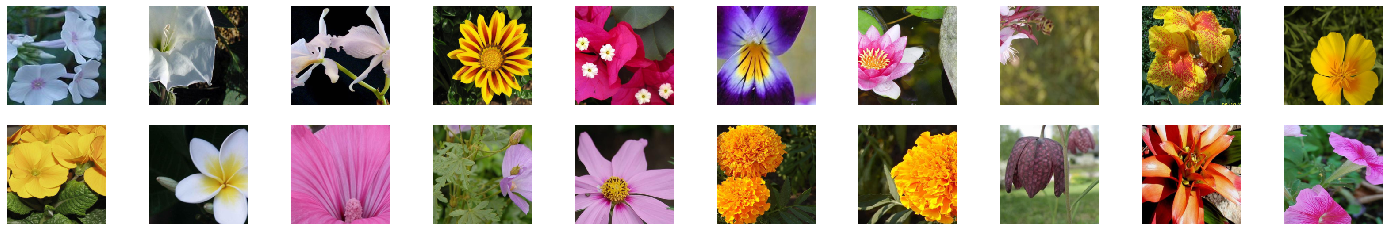

In [11]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    

MODEL

In [12]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [13]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 55889155.31it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [0]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [16]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 102 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 102)

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

102


In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [18]:
# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 4.6953235387802126
Epoch 1, Batch 40 loss: 4.6204994678497311
Epoch 2, Batch 20 loss: 4.5357936620712280
Epoch 2, Batch 40 loss: 4.5137041330337526
Epoch 3, Batch 20 loss: 4.4345270872116087
Epoch 3, Batch 40 loss: 4.3634466648101808
Epoch 4, Batch 20 loss: 4.3203080177307127
Epoch 4, Batch 40 loss: 4.2918552637100218
Epoch 5, Batch 20 loss: 4.2351394414901735
Epoch 5, Batch 40 loss: 4.1916356325149540
Epoch 6, Batch 20 loss: 4.1391429543495182
Epoch 6, Batch 40 loss: 4.1161861300468443
Epoch 7, Batch 20 loss: 4.0767508149147034
Epoch 7, Batch 40 loss: 4.0103228569030760
Epoch 8, Batch 20 loss: 3.9728073596954347
Epoch 8, Batch 40 loss: 3.9286792159080504
Epoch 9, Batch 20 loss: 3.8793863534927366
Epoch 9, Batch 40 loss: 3.8318404316902162
Epoch 10, Batch 20 loss: 3.7859792947769164
Epoch 10, Batch 40 loss: 3.7877822279930116
Epoch 11, Batch 20 loss: 3.6971094846725463
Epoch 11, Batch 40 loss: 3.6591747283935545
Epoch 12, Batch 20 loss: 3.6236636281013488
Epoch 

In [28]:
# track test loss 
# over 102 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(49):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.973713


Test Accuracy (Overall): 76% (261/343)
